In [1]:
import pickle;
import numpy as np;
from numpy.linalg import pinv;
from numpy.polynomial.legendre import legvander;
import tensorflow as tf

import control

In [10]:
import matplotlib
import matplotlib.pyplot as plt;
matplotlib.rcParams.update({'font.size':20}) # default font size on (legible) figures
# colors =[[ 0.68627453,  0.12156863,  0.16470589],
#        [ 0.96862745,  0.84705883,  0.40000001],
#        [ 0.83137256,  0.53333336,  0.6156863 ],
#        [ 0.03529412,  0.01960784,  0.14509805],
#        [ 0.90980393,  0.59607846,  0.78039217],
#        [ 0.69803923,  0.87843138,  0.72941178],
#        [ 0.20784314,  0.81568629,  0.89411765]];

colors = [[255,158,74],[237,102,93],[173,139,201],\
          [114,158,206],[103,191,92],[237,151,202],\
          [205,204,93],[168,120,110],[162,162,162],[109,204,218],[ 0.68627453,  0.12156863,  0.16470589],
       [ 0.96862745,  0.84705883,  0.40000001],
       [ 0.83137256,  0.53333336,  0.6156863 ],
       [ 0.03529412,  0.01960784,  0.14509805],
       [ 0.90980393,  0.59607846,  0.78039217],
       [ 0.69803923,  0.87843138,  0.72941178],
       [ 0.20784314,  0.81568629,  0.89411765]]

colors = np.asarray(colors)/255; # defines a color palette 


In [3]:
def load_pickle_data(file_path,has_control,has_output):
        '''load pickle data file for deep Koopman dynamic mode decomposition. 
        Args: 
           file_path: 

        '''     
        file_obj = open(file_path,'rb');
        output_vec = pickle.load(file_obj);
        print(type(output_vec))
        Xp = None;
        Xf = None;
        Yp = None;
        Yf = None;
        Up = None;
        
        if type(output_vec) == list:
          Xp = output_vec[0]; # list of baseline observables, len(Yp) = (n_samps-1) 
          Xf = output_vec[1]; # list of baseline observables, len(Yf) = (n_samps-1)
          if has_control:
            Up = output_vec[2];
          if has_output:
            Yp = output_vec[3];
            Yf = output_vec[4]; 
            #print(Up[0:10]
          if len(Xp)<2:
            print("Warning: the time-series data provided has no more than 2 points.")
            
        if type(output_vec) == dict:
          Xp = output_vec['Xp'];
          Xf = output_vec['Xf'];
          Yp = output_vec['Yp'];
          Yf = output_vec['Yf'];
          if has_control:
            Up = output_vec['Up'];
          if has_output:
            Yp = output_vec['Yp'];
            Yf = output_vec['Yf']; 
          if len(Xp)<2:
            print("Warning: the time-series data provided has no more than 2 points.")
    
          
        #print("DEBUG:") + repr(len(output_vec));
          

        X_whole = [None]*(len(Xp)+1);
        
        for i in range(0,len(Xp)+1):
            if i == len(Xp):
                X_whole[i] = Xf[i-1];
            else:
                X_whole[i] = Xp[i];

        X_whole = np.asarray(X_whole);
        
        return np.asarray(Xp),np.asarray(Xf),X_whole,Up,Yp,Yf

In [4]:
with_control = 1;

sess = tf.InteractiveSession();

saver = tf.train.import_meta_graph('combinatorial_promoters_AH.pickle.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'));

psiyp = tf.get_collection('psiyp')[0];
psiyf = tf.get_collection('psiyf')[0];

if with_control:
    forward_prediction_control = tf.get_collection('forward_prediction_control')[0];
else:
    forward_prediction = tf.get_collection('forward_prediction')[0];
    
yp_feed = tf.get_collection('yp_feed')[0];
yf_feed = tf.get_collection('yf_feed')[0];
Kx = tf.get_collection('Kx')[0];
Kx_num = sess.run(Kx);
A = np.transpose(Kx_num); # Kx_num and Ku_num were defined using row multi. 

if with_control:
    psiu = tf.get_collection('psiu')[0];
    u_control = tf.get_collection('u_control')[0];
    Ku = tf.get_collection('Ku')[0];
    Ku_num = sess.run(Ku);
    B = np.transpose(Ku_num);




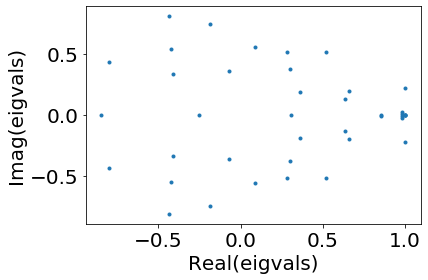

In [5]:
[d,v] = np.linalg.eig(Kx_num)
# print(np.max(np.abs(d)))
# print(np.real(v[:,np.argmax(np.abs(d))]))

plt.figure();
plt.plot(np.real(d),np.imag(d),'.');
plt.xlabel('Real(eigvals)')
plt.ylabel('Imag(eigvals)')

import control

sys = control.ss(Kx_num,B,np.eye(Kx_num.shape[0]),np.zeros( ( A.shape[0],B.shape[1]) ))
# control.dlyap(Kx_num,np.dot(B,B.T))


In [7]:
data_directory = 'koopman_data/'
data_suffix = 'combinatorial_promoters_AH.pickle';
data_file = data_directory + data_suffix;
Yp,Yf,Ywhole,u_control_all_training,fake_outputp,fake_outputf = load_pickle_data(data_file,1,0);
with_control = 1;
Y_p_old = Yp

num_trains = len(Yp)*5.0/10;
train_indices = range(0,np.int(num_trains),1);#np.random.randint(0,len(Yp),num_trains)
test_indices = range(np.int(num_trains),len(Yp),1);#np.random.randint(0,len(Yp),len(Yp)-num_trains);

num_bas_obs = len(Yp[0]);
print("[INFO]: Number of training datapoints " + repr(num_trains));
print("[INFO]: Number of state components: " + repr(len(Yp[0])));


if with_control:
    U_test = u_control_all_training[test_indices,:];
    U_train = u_control_all_training[train_indices,:];
    n_inputs_control = u_control_all_training.shape[1]

<class 'list'>
[INFO]: Number of training datapoints 10000.0
[INFO]: Number of state components: 11


###  N-Step Prediction Visualization ###

In [28]:
Y_p_old.shape

(20000, 11)

[RESULT] n-step prediction error for trajectory 0 : 0.241772


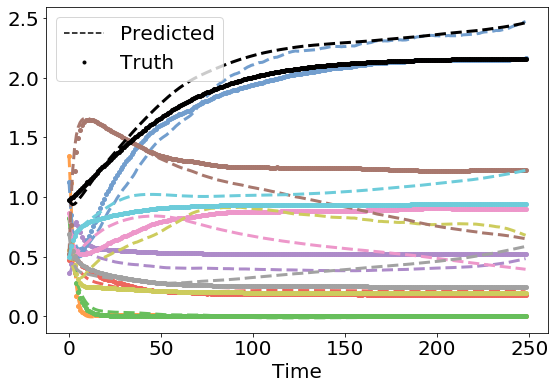

In [31]:
# # # - - - n-step Prediction Error Analysis - - - # # # 

for traj in [0]: #list(np.arange(1,20,2)):  
    n_points_pred = 249 #int(len(Y_p_old) - test_indices[0]-1);

    init_index = int(test_indices[0]+traj*249);
    Yf_final_test_stack_nn = np.asarray(Y_p_old).T[:,init_index:(init_index+1)+n_points_pred]
    Ycurr = np.asarray(Y_p_old).T[:,init_index]
    Ycurr = np.transpose(Ycurr);
    if with_control:
        Uf_final_test_stack_nn = np.asarray(u_control_all_training).T[:,init_index:(init_index+1)+n_points_pred]

    #Reshape for tensorflow, which operates using row multiplication. 
    Ycurr = Ycurr.reshape(1,num_bas_obs);
    psiyp_Ycurr = psiyp.eval(feed_dict={yp_feed:Ycurr});
    psiyf_Ycurr = psiyf.eval(feed_dict={yf_feed:Ycurr});


    ## Define a growing list of vector valued observables that is the forward prediction of the Yf snapshot matrix, initiated from an initial condition in Yp_final_test.   
    Yf_final_test_ep_nn = [];  #Variable to store final Test Predictions of Yforwrad snapshots, using an extended or multi-step prediction approach on the deepDMD basis.  
    Yf_final_test_ep_nn.append(psiyp_Ycurr.tolist()[0][0:num_bas_obs]); # append the initial seed state value.

    for i in range(0,n_points_pred):
      if with_control:
        if len(U_test[i,:])==1:
          U_temp_mat = np.reshape(Uf_final_test_stack_nn[i,:],(1,1));
          psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});#
        else:
          U_temp_mat = np.reshape(Uf_final_test_stack_nn.T[i,:],(1,n_inputs_control));
          psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});# 
      else:
        psiyp_Ycurr = sess.run(forward_prediction,feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs]});

      Yout = psiyp_Ycurr.tolist()[0][0:num_bas_obs];
      Yf_final_test_ep_nn.append(Yout);


    Yf_final_test_ep_nn = np.asarray(Yf_final_test_ep_nn);
    Yf_final_test_ep_nn = np.transpose(Yf_final_test_ep_nn);

    prediction_error = np.linalg.norm(Yf_final_test_stack_nn-Yf_final_test_ep_nn,ord='fro')/np.linalg.norm(Yf_final_test_stack_nn,ord='fro');
    print('%s%f' % ('[RESULT] n-step prediction error for trajectory ' + str(traj) +' : ',prediction_error));

    import matplotlib
    matplotlib.rcParams.update({'font.size':20})

    plt.figure(figsize=(9,6))
    ### Make a Prediction Plot
    x_range = np.arange(0,n_points_pred,1)
    #x_range = np.arange(0,Yf_final_test_stack_nn.shape[1],1);
    for i in range(0,num_bas_obs):
        g = plt.plot(x_range,Yf_final_test_stack_nn[i,0:len(x_range)],'.',color=colors[i,:],ms=8);
        h = plt.plot(x_range,Yf_final_test_ep_nn[i,0:len(x_range)],color=colors[i,:],linewidth=3,linestyle='--');
    axes = plt.gca();
    # axes.spines['right'].set_visible(False)
    # axes.spines['top'].set_visible(False)
    
#     plt.title('trajectory ' + str(traj))

    # plt.legend(loc='best');
    # plt.legend((h[0],g[0]),('Predicted','Truth'),loc='best');
    # leg = axes.get_legend()
    # leg.legendHandles[0].set_color('black')
    # leg.legendHandles[1].set_color('black')
    plt.xlabel('Time');
    #plt.ylim([0,3.0])
    # fig = plt.gcf();

    import matplotlib.lines as mlines
    black_line = mlines.Line2D([], [], color='black',linestyle='--',label='Predicted')
    black_dot = mlines.Line2D([], [],linestyle='',color='black',marker='.',label='Truth')
    plt.legend(handles=[black_line,black_dot]);

    import os
    filename = 'incoherent_ff_loop_final_nstep_prediction.pdf'
    path = '/users/aqib/desktop/ucsb/research/bccl/koopman_ss_prog/code/combinatorial_promoters'
    fullpath = os.path.join(path, filename)
#     target_file = data_suffix.replace('.pickle','')+'final_nstep_prediction.pdf';
    target_file = fullpath
#     plt.savefig(target_file);
#     plt.show();

In [34]:
# dataDump = {'Kx':Kx_num,'Ku':Ku_num}
# filename = 'combinatorial_promoter_deepDMD_model.pickle'
# path = '/users/aqib/desktop/ucsb/research/bccl/koopman_ss_prog/code/combinatorial_promoters'
# fullpath = os.path.join(path, filename)
# # pickle.dump( data, open( 'filename.picle', 'wb' ) )
# # data = pickle.load( open( 'filename.pickle', 'rb' ) )
# pickle.dump(dataDump,open(fullpath,'wb'))